# **Melanoma Detection**

The objective of this work is to build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
#Installing package that is required (To address class imbalance)
!pip install Augmentor

In [57]:
#Importing necessary libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import Augmentor
from glob import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims


In [ ]:
#Mounting drive to import dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Import

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). 

We will import both train and test dataset. The test dataset will be used to evaluate the model performance

In [ ]:
#Importing Data
#Defining the path where the data is stored
data_dir_train = pathlib.Path('/content/drive/MyDrive/Skin Cancer Data/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Skin Cancer Data/Test')

In [ ]:
#counting the number of images present in the train set
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print("Train dataset contains:" , image_count_train, "images")

#counting the number of images present in the test set
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print("Test dataset contains:" , image_count_test, "images")


Train dataset contains: 2239 images
Test dataset contains: 118 images


## Dataset Creation

In this section, we will use 80 percent of the images for training and the remaining 20 percent for validation. The images will be resized to 180 X 180 and a batch size of 32 will be used.

In [ ]:
#Defining loader parameters 
#The params will be used accross all models
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
#define train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123,
  validation_split=0.2,
  subset="training")
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
#define validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  batch_size=batch_size,
  image_size=(img_height, img_width),
  seed=123,
  validation_split=0.2,
  subset="validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
#Storing all classes of skin cancer in a variable 
class_names = train_ds.class_names
#View the classes present
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Data Visualization

We will visualize one image from each classes present in the dataset

In [46]:
def visualize_image(directory):
    columns = 3
    for i in range(len(class_names)): 
      plt.subplot(columns, columns, i + 1)
      image_dir = list(directory.glob(class_names[i]+'/*.jpg'))[1]
      print (image_dir)
      display_image = plt.imread(str(image_dir))
      plt.title(class_names[i])
      plt.imshow(display_image)
      plt.axis("off")

/content/drive/MyDrive/Skin Cancer Data/Train/actinic keratosis/ISIC_0026650.jpg
/content/drive/MyDrive/Skin Cancer Data/Train/basal cell carcinoma/ISIC_0025601.jpg
/content/drive/MyDrive/Skin Cancer Data/Train/dermatofibroma/ISIC_0027141.jpg
/content/drive/MyDrive/Skin Cancer Data/Train/melanoma/ISIC_0000144.jpg
/content/drive/MyDrive/Skin Cancer Data/Train/nevus/ISIC_0000041.jpg
/content/drive/MyDrive/Skin Cancer Data/Train/pigmented benign keratosis/ISIC_0024850.jpg
/content/drive/MyDrive/Skin Cancer Data/Train/seborrheic keratosis/ISIC_0010878.jpg
/content/drive/MyDrive/Skin Cancer Data/Train/squamous cell carcinoma/ISIC_0025029.jpg
/content/drive/MyDrive/Skin Cancer Data/Train/vascular lesion/ISIC_0024662.jpg


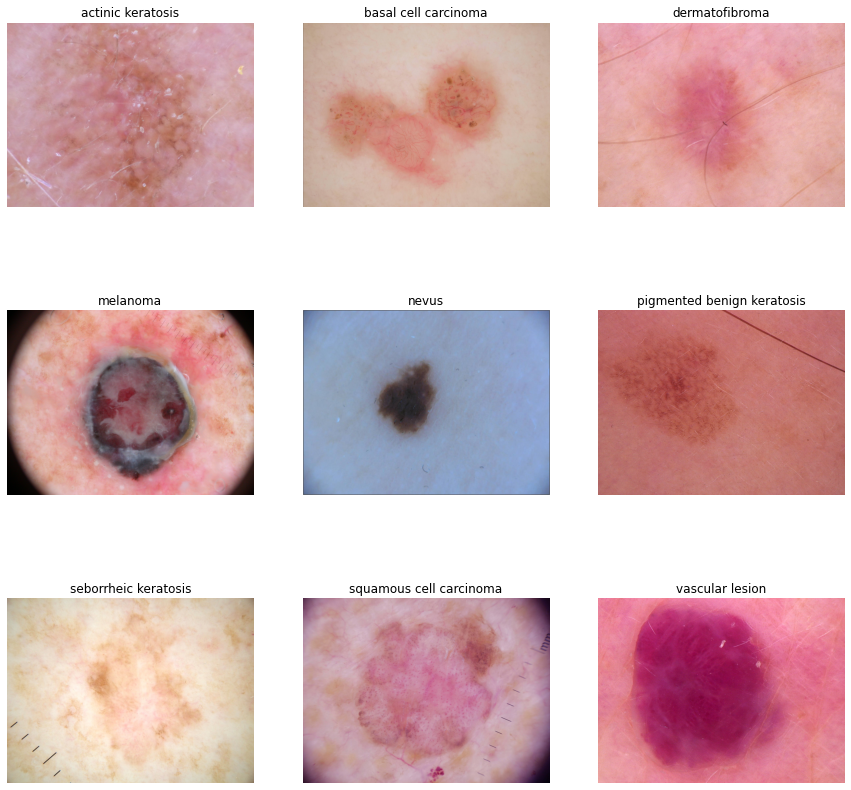

In [47]:
plt.figure(figsize=(15,15))
#call function to display images
visualize_image(data_dir_train)

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Build

### Model 1 

The first model is built on the train set without performing any data preparation or class imbalance fixes. We will use a sequential model and define a linear stack of layers. 

#### Model Architecture

The activation function that will be used is Rectified Linear Unit (ReLU). One main advantage of ReLU is that it does not activate all the neurons at the same time and hence faster execution

Softmax activation function will be used in the output layer.

In [15]:
num_classes = 9

#Define the sequential model and added a preprocessing layer which rescales input values to (0,1)
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

#Added convolutional layers
#Applied 16 convolution filters of size 3x3 each, with even padding of around the images
model.add(Conv2D(16, (3, 3), padding='same',input_shape=(180, 180, 3)))
model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2 
model.add(MaxPooling2D(pool_size=(2, 2)))

#Applied 32 convolution filters of size 3x3 each, with even padding of around the images
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2 
model.add(MaxPooling2D(pool_size=(2, 2)))

#Applied 64 convolution filters of size 3x3 each, with even padding of around the images
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2 
model.add(MaxPooling2D(pool_size=(2, 2)))

#Applied dropout and set the rate to 50%
model.add(Dropout(0.5))

#Added a flatten layer followed by two dense layers
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(num_classes, activation = "softmax"))

#### Model Compilation

The optimizer that was chosen is Adam optimizer because it is known to perform generally better compared to other optimizer. It also have faster computation time. 
As for the loss function, sparse_categorical_crossentropy (scce) will be used and it produces a category index of the most likely matching category.

In [17]:
#compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 activation (Activation)     (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 88, 88, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 88, 88, 32)        0         
                                                        

#### Model Training

The first model will be trained for 20 epochs.

In [20]:
model_epochs = 20
#training the model
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=model_epochs
)

Epoch 1/20
56/56 [==============================] - 48s 878ms/step - loss: 2.0447 - accuracy: 0.2483 - val_loss: 1.8122 - val_accuracy: 0.3468
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6744 - accuracy: 0.3945 - val_loss: 1.5692 - val_accuracy: 0.4519
Epoch 3/20
56/56 [==============================] - 1s 23ms/step - loss: 1.5268 - accuracy: 0.4503 - val_loss: 1.5667 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 1s 23ms/step - loss: 1.4252 - accuracy: 0.4944 - val_loss: 1.4073 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 1s 23ms/step - loss: 1.3216 - accuracy: 0.5340 - val_loss: 1.3443 - val_accuracy: 0.5302
Epoch 6/20
56/56 [==============================] - 1s 23ms/step - loss: 1.2456 - accuracy: 0.5497 - val_loss: 1.3707 - val_accuracy: 0.5481
Epoch 7/20
56/56 [==============================] - 2s 27ms/step - loss: 1.1875 - accuracy: 0.5843 - val_loss: 1.3376 - val_accuracy: 0.5436
Epoch 8/20


#### Model Evaluation

We will analyse the model performance by plotting the training accuracy and loss against the validation accuracy and loss.


In [21]:
#writing it as a function to avoid code redundancy
def plot_performance(epochs, history):

  #getting train and validation accuracy
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  #getting train and validation loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(25, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

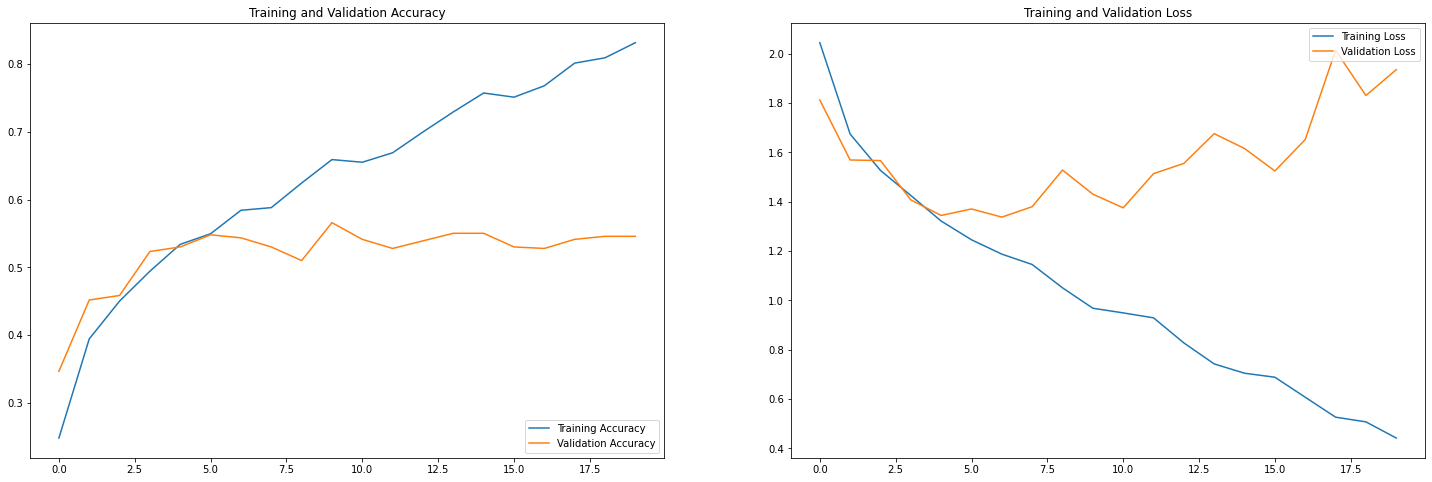

In [22]:
#plotting graph to visualize model performance
plot_performance(model_epochs, history)

**Observations**

1. Looking at the graphs, it can be deduced that the model is clealy overfitting.
2. After the 20th epochs, the validation accuracy is 0.55 while the training accuracy is 0.83. This huge gap is evidence of overfitting. 
3. The difference between the validation loss and training loss is significant too.
4. In short, it seems like the model have memorised the training data.

### Model 2

#### Performing Augmentation 

We will use ImageDataGenerator from keras library to perform augmentation. 
The ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.
The main operations that will be performed are random rotation, flips, scaling and brightness adjustments. We will not perform any zoom operation because it might zoom in and capture non affected areas of the skin.

In [65]:
#Initialising the image data generator
train_datagen = ImageDataGenerator(
        rescale=1./255, #normalizing the pixel values between (0,1)
        rotation_range=10,  
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=True,
        validation_split=0.2)

We will still only use 20% of the total images as validation set.

In [45]:
seed_num = 123

#Creating train data from the augementor 
train_data = train_datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes=class_names,
        seed = seed_num,
        subset='training')

#Creating validation data from the augementor 
val_data = train_datagen.flow_from_directory(
        data_dir_train,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        classes=class_names,
        seed = seed_num,
        subset='validation')


Found 1795 images belonging to 9 classes.
Found 444 images belonging to 9 classes.


**Visualizing effect of augmentation**

/content/drive/MyDrive/Skin Cancer Data/Train/basal cell carcinoma/ISIC_0025601.jpg


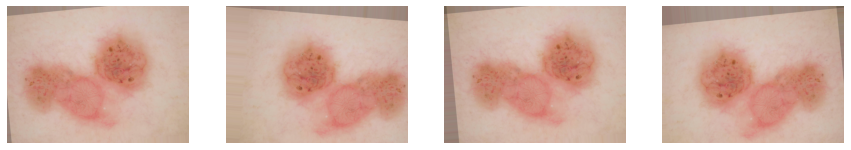

In [77]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
image_path = []
for i in range(len(class_names)): 
  image_dir = list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]
  image_path.append(image_dir)

print(image_path[1])
sample_image = img_to_array(load_img(image_path[1]))
sample_image = expand_dims(sample_image, 0)

aug_iter = train_datagen.flow(sample_image, batch_size=1)

# generate samples and plot
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
# generate batch of images
for i in range(4):
	# convert to unsigned integers
	image = next(aug_iter)[0]
	# plot image
	ax[i].imshow(image)
	ax[i].axis('off')

We notice that the image was flipped, rotated and scaled.

#### Model Architecture

We will make slight changes to the second model so as to improve the performance.

We have already normalized the images when we augmented them using the Image data generator 

An extra layer of 32 convolution filters will be added followed by an extra drop out layer with a rate as 25%.

In [78]:
num_classes = 9

#Define the sequential model 
secnd_model = Sequential()

#Added convolutional layers
#Applied 16 convolution filters of size 3x3 each, with even padding of around the images
secnd_model.add(Conv2D(16, (3, 3), padding='same',input_shape=(180, 180, 3)))
secnd_model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2 
secnd_model.add(MaxPooling2D(pool_size=(2, 2)))

#Applied 32 convolution filters of size 3x3 each, with even padding of around the images
secnd_model.add(Conv2D(32, (3, 3),padding='same'))
secnd_model.add(Activation('relu'))

secnd_model.add(Conv2D(32, (3, 3),padding='same'))
secnd_model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2 
secnd_model.add(MaxPooling2D(pool_size=(2, 2)))

#Applied dropout and set the rate to 25%
secnd_model.add(Dropout(0.25))

#Applied 64 convolution filters of size 3x3 each, with even padding of around the images
secnd_model.add(Conv2D(64, (3, 3), padding='same'))
secnd_model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2 
secnd_model.add(MaxPooling2D(pool_size=(2, 2)))

#Applied dropout and set the rate to 50%
secnd_model.add(Dropout(0.5))

#Added a flatten layer followed by two dense layers
secnd_model.add(Flatten())
secnd_model.add(Dense(128, activation = "relu"))
secnd_model.add(Dense(num_classes, activation = "softmax"))

#### Model Compilation

Adam optimizer will be used and the we changed the loss function to categorical_crossentropy for the second model.

In [80]:
#compiling the model
secnd_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [81]:
# View the summary of all layers
secnd_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_3 (Activation)   (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 activation_4 (Activation)   (None, 90, 90, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        9248      
                                                      

#### Model Training

Additionally we will add a callback of early stopping, it will stop the training when the validation accuracy has stopped improving. It is a form of regulization of some sort to avoid overfitting. The second model will also be trained for 20 epochs. 

In [82]:
#Early stopping to monitor validation accuracy and stops after 5 epochs of no improvement
#Verbose 1 displays messages when the callback takes an action.
callback = EarlyStopping(monitor='val_accuracy', patience=5, mode="auto",verbose=1)

In [83]:
secnd_model_epochs = 20
#Training the model
history = secnd_model.fit(
  train_data,
  validation_data=val_data,
  epochs=secnd_model_epochs,
  callbacks=[callback]
)

Epoch 1/20
57/57 [==============================] - 55s 948ms/step - loss: 2.1508 - accuracy: 0.1955 - val_loss: 1.9794 - val_accuracy: 0.1847
Epoch 2/20
57/57 [==============================] - 58s 1s/step - loss: 1.9408 - accuracy: 0.2474 - val_loss: 1.8094 - val_accuracy: 0.2995
Epoch 3/20
57/57 [==============================] - 54s 961ms/step - loss: 1.7525 - accuracy: 0.3705 - val_loss: 1.7155 - val_accuracy: 0.3716
Epoch 4/20
57/57 [==============================] - 49s 864ms/step - loss: 1.5963 - accuracy: 0.4440 - val_loss: 1.6421 - val_accuracy: 0.4234
Epoch 5/20
57/57 [==============================] - 53s 930ms/step - loss: 1.4904 - accuracy: 0.4864 - val_loss: 1.6970 - val_accuracy: 0.4279
Epoch 6/20
57/57 [==============================] - 49s 854ms/step - loss: 1.4950 - accuracy: 0.4669 - val_loss: 1.5936 - val_accuracy: 0.4459
Epoch 7/20
57/57 [==============================] - 49s 866ms/step - loss: 1.4769 - accuracy: 0.4875 - val_loss: 1.7551 - val_accuracy: 0.4234
Ep

#### Model Evaluation

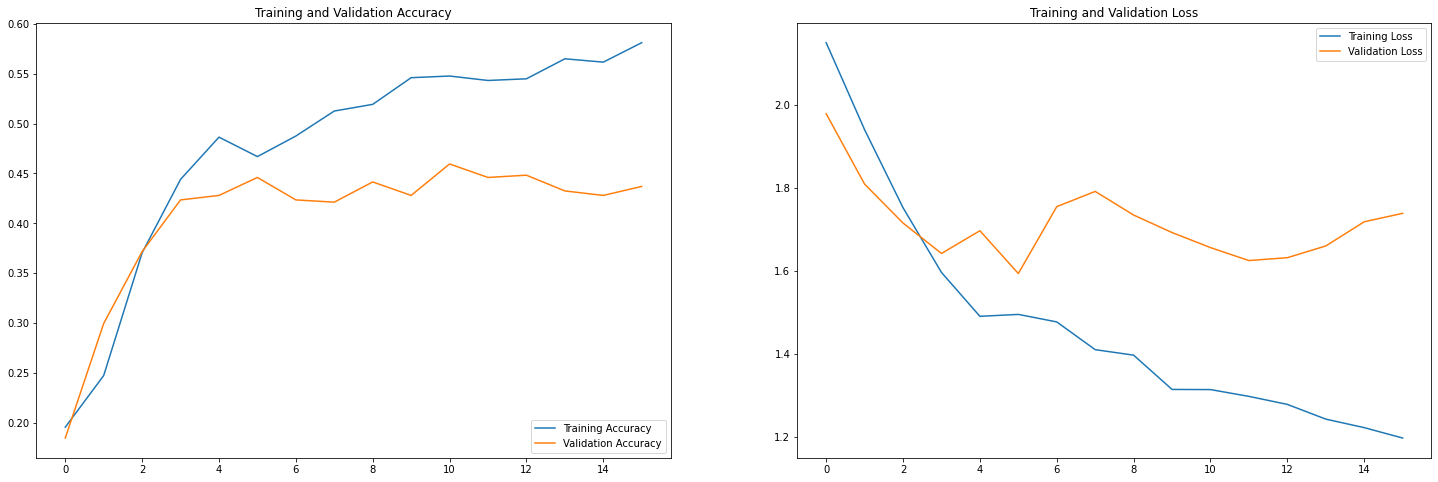

In [84]:
#plotting graph to visualize model performance
plot_performance(16, history)

**Observations** 
1. There is still a huge difference between the training accuracy and validation accuracy.  
2. With every epochs, the training accuracy keep increasing significantly and it stopped at 16th epochs because of early stopping mechanism. It is safe to say that with additional training would have resulted in an overfitting model. 
3. The validation loss is also 50% worse when compared to the training loss.
4. The augmentation strategy did not really improve the model because the ImageDataGenerator only transform the existing images and the class imbalance issues are still present

### Class Distribution Analysis

In this section, we will analyse the number of images in each class and determine if class imbalance is present

In [85]:
#define col name for dataframe
cols = ['Class Names', 'Image Count']
c_list = []

#looping the subdirectories in the train folder
for element in os.listdir(data_dir_train):
    element_path=os.path.join(data_dir_train, element)

    #Setting count to 0 before accessing each subdirectory
    count = 0
    #looping and counting images inside each subfolders
    for image in os.listdir(element_path):
          image_path=os.path.join(element_path, image)
          if os.path.isfile(image_path):
            count+=1

    #appending the class and image count to the list
    c_list.append([element, count])

#Converting to dataframe
pd_df = pd.DataFrame(c_list, columns=cols)
#print the result
pd_df

,Class Names,Image Count
0,melanoma,438
1,actinic keratosis,114
2,pigmented benign keratosis,462
3,nevus,357
4,vascular lesion,139
5,squamous cell carcinoma,181
6,basal cell carcinoma,376
7,seborrheic keratosis,77
8,dermatofibroma,95


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


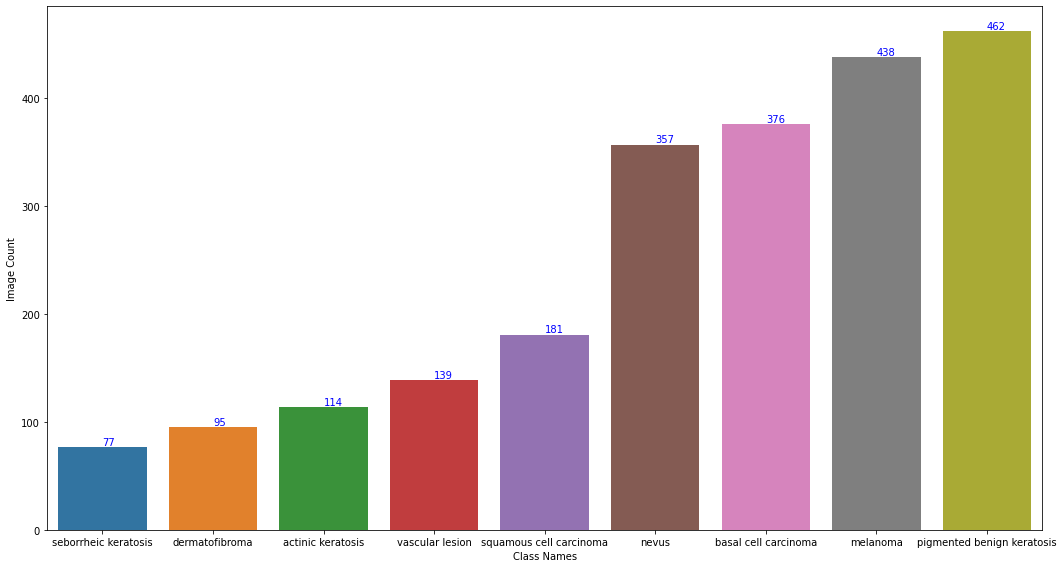

In [86]:
#Visualizing the class distribution 
plt.figure(figsize=(15,8))

#Sorting the values for better visualization
pd_df = pd_df.sort_values(['Image Count']).reset_index(drop=True)

# plot barh chart with index as x values
ax = sns.barplot(pd_df['Class Names'], pd_df['Image Count'])
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="Class Names", ylabel='Image Count')

# add proper Image count values as x labels
ax.set_xticklabels(pd_df['Class Names'])
for i, v in enumerate(pd_df["Image Count"].iteritems()):        
    ax.text(i ,v[1], "{:,}".format(v[1]), color='b', va ='bottom')
plt.tight_layout()
plt.show()

#### Findings:
- Which class has the least number of samples? 
  Seborrheic keratosis is the class with least number of samples. It has 77    samples. 
- Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis class has the maximum samples of 462 followed by Melanoma class with 438 samples.

### Model 3 

Given that the train dataset contain class imbalance, we will address this issue by using Augmentor library and then build the final model to check for performance improvement. 

The Augmentor library is designed to aid the augmentation and artificial generation of image data.

#### Class Imbalance Rectification

To use Augmentor, the following general procedure is followed:

- Instantiate a Pipeline object pointing to a directory containing your initial image data set.
- Define a number of operations to perform on this data set using your Pipeline object.
- Execute these operations by calling the Pipeline’s sample() method.


In [87]:
path_to_training_dataset="/content/drive/MyDrive/Skin Cancer Data/Train/"
#loop the nine classes and proceed to add samples in each
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    #perform rotation
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) # Adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Skin Cancer Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD3040AC90>: 100%|██████████| 500/500 [00:19<00:00, 25.55 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Skin Cancer Data/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD300B2190>: 100%|██████████| 500/500 [00:19<00:00, 25.42 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Skin Cancer Data/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD302D7F90>: 100%|██████████| 500/500 [00:20<00:00, 23.94 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Skin Cancer Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FDDFD383850>: 100%|██████████| 500/500 [01:38<00:00,  5.10 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Skin Cancer Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7FDDF03FF2D0>: 100%|██████████| 500/500 [01:26<00:00,  5.75 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Skin Cancer Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD31462D90>: 100%|██████████| 500/500 [00:19<00:00, 26.22 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Skin Cancer Data/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FDDFD4BE150>: 100%|██████████| 500/500 [00:43<00:00, 11.56 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Skin Cancer Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD30574710>: 100%|██████████| 500/500 [00:18<00:00, 26.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Skin Cancer Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FDD6CCE6450>: 100%|██████████| 500/500 [00:19<00:00, 25.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. We will count of the number of augmented images generated

In [ ]:
#count augmented images generated
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


Checking the distribution of augmented images across all classes


In [88]:
#getting the path where the generated images are stored
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [89]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [90]:
#storing the count of generated images for each classes in a dataframe
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [91]:
#print the count of each classes (augmented images)
new_df['Label'].value_counts()

melanoma                      500
actinic keratosis             500
pigmented benign keratosis    500
nevus                         500
vascular lesion               500
squamous cell carcinoma       500
basal cell carcinoma          500
seborrheic keratosis          500
dermatofibroma                500
Name: Label, dtype: int64

**Training Dataset Creation**

In [92]:
data_dir_train="/content/drive/MyDrive/Skin Cancer Data/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_num, ## seed 123 defined above
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Validation Dataset Creation**

In [93]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=seed_num,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Model Architecture

We tried using batch normalization on the final model but that jst worsened the performance. So instead, we added an extra pooling layer after the second convolution layer.


In [99]:
num_classes = 9

#Define the sequential model and added a preprocessing layer which rescales input values to (0,1)
final_model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

#Added convolutional layers
#Applied 16 convolution filters of size 3x3 each, with even padding of around the images
final_model.add(Conv2D(16, (3, 3), padding='same',input_shape=(180, 180, 3)))
final_model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2 
final_model.add(MaxPooling2D(pool_size=(2, 2)))

#Applied 32 convolution filters of size 3x3 each, with even padding of around the images
final_model.add(Conv2D(32, (3, 3),padding='same'))
final_model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2 
final_model.add(MaxPooling2D(pool_size=(2, 2)))

final_model.add(Conv2D(32, (3, 3),padding='same'))
final_model.add(Activation('relu'))
#Added a max pooling layer of window size 2X2 
final_model.add(MaxPooling2D(pool_size=(2, 2)))

#Applied dropout and set the rate to 25%
final_model.add(Dropout(0.25))

#Applied 64 convolution filters of size 3x3 each, with even padding of around the images
final_model.add(Conv2D(64, (3, 3), padding='same'))
final_model.add(Activation('relu'))

#Added a max pooling layer of window size 2X2 
final_model.add(MaxPooling2D(pool_size=(2, 2)))

#Applied dropout and set the rate to 50%
final_model.add(Dropout(0.5))

#Added a flatten layer followed by two dense layers
final_model.add(Flatten())
final_model.add(Dense(128, activation = "relu"))
final_model.add(Dense(num_classes, activation = "softmax"))

#### Model Compilation

We will use adam for optimiser and sparse categorical Cross Entropy for loss function.

In [100]:
#compiling the final model
final_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [101]:
#view model summary
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 activation_11 (Activation)  (None, 180, 180, 16)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 activation_12 (Activation)  (None, 90, 90, 32)        0         
                                                      

#### Model Training

We will still employ the early stopping mechanism with a patience level of 5 and the final model will be trained for 30 epochs

In [105]:
#Early stopping to monitor validation accuracy
callback = EarlyStopping(monitor='val_accuracy', patience=5, mode="auto",verbose=1)

In [103]:
#Training the final model
history = final_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=30,
  callbacks=[callback]
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


169/169 [==============================] - 30s 170ms/step - loss: 2.1825 - accuracy: 0.1435 - val_loss: 2.0963 - val_accuracy: 0.2153
Epoch 2/30
169/169 [==============================] - 29s 168ms/step - loss: 1.7540 - accuracy: 0.3249 - val_loss: 1.7114 - val_accuracy: 0.3267
Epoch 3/30
169/169 [==============================] - 29s 167ms/step - loss: 1.5244 - accuracy: 0.4114 - val_loss: 1.4337 - val_accuracy: 0.4692
Epoch 4/30
169/169 [==============================] - 30s 169ms/step - loss: 1.3901 - accuracy: 0.4642 - val_loss: 1.3337 - val_accuracy: 0.5100
Epoch 5/30
169/169 [==============================] - 29s 168ms/step - loss: 1.3020 - accuracy: 0.5011 - val_loss: 1.2020 - val_accuracy: 0.5650
Epoch 6/30
169/169 [==============================] - 29s 169ms/step - loss: 1.2299 - accuracy: 0.5282 - val_loss: 1.2027 - val_accuracy: 0.5583
Epoch 7/30
169/169 [==============================] - 29s 168ms/step - loss: 1.1387 - accuracy: 0.5695 - val_loss: 1.1182 - val_accuracy: 0.5

#### Model Evaluation

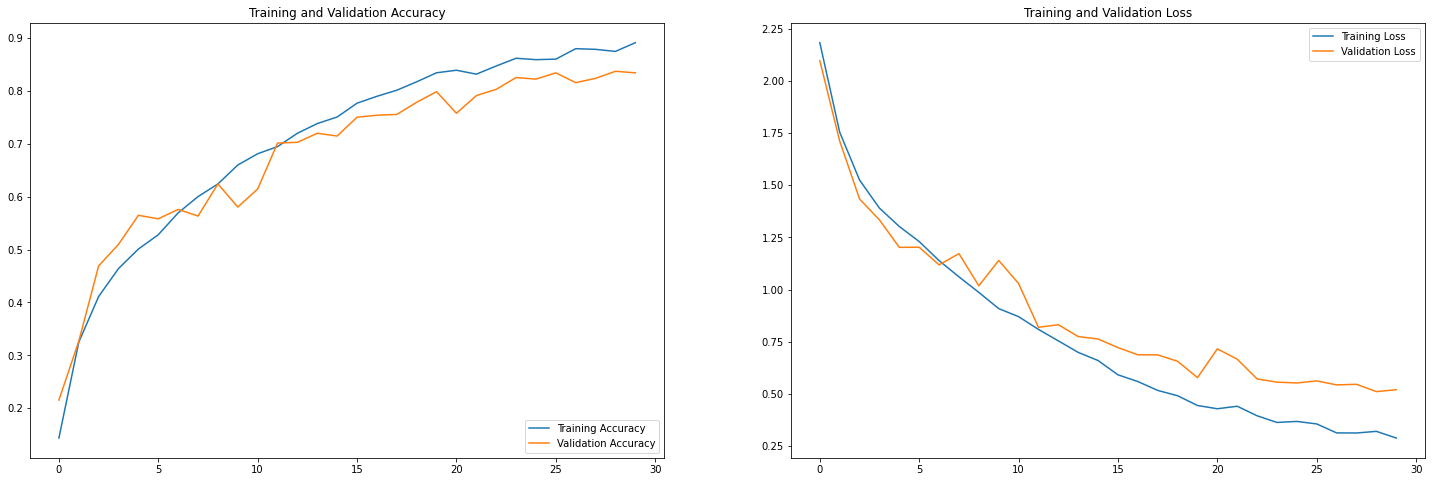

In [106]:
#plot the accuracy and loss 
plot_performance(30, history)

**Observations**

1. The model performance has significantly improved after we rectified the class imbalance issue. 
2. The training accuracy is 89% while the validation accuracy is 83%. Even the loss between training and validation set has reduced to an acceptable range
3. This is the model that we will use to make prediction on the test set 